In [32]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from google.cloud import storage
from io import BytesIO

In [33]:
random_stat = 123

storage_client = storage.Client(project = 'ih-final-project-277919')
bucket = storage_client.get_bucket("data_images_ih")

SIZE = 416


In [34]:
#!git clone https://github.com/pjreddie/darknet.git

# Build gpu version darknet
#!cd darknet && sed '1 s/^.*$/GPU=1/; 2 s/^.*$/CUDNN=1/' -i Makefile

# -j <The # of cpu cores to use>. Chang 999 to fit your environment. Actually i used '-j 50'.
#!cd darknet && make -j 999 -s
#!cp darknet/darknet darknet_gpu

In [35]:
#!wget -q https://pjreddie.com/media/files/darknet53.conv.74

In [36]:
DATA_PATH = '/home/jupyter/data/'

#TRAIN_PATH = os.path.join(DATA_PATH, "train_images")
#TEST_PATH = os.path.join(DATA_PATH, "test_images")

FRAME_PATH = os.path.join(os.getcwd(), 'images')  # .jpg
MASK_PATH = os.path.join(os.getcwd(), 'labels')  # .txt
METADATA_PATH = os.path.join(os.getcwd(), 'metadata') # .txt

# YOLOv3 config file directory
CONFIG_PATH = os.path.join(os.getcwd(), 'cfg')
# YOLOv3 training checkpoints will be saved here
BACKUP_PATH = os.path.join(os.getcwd(), 'backup')

for directory in [FRAME_PATH, MASK_PATH, METADATA_PATH, CONFIG_PATH, BACKUP_PATH ]:
    if os.path.isdir(directory):
        continue
    os.mkdir(directory)

In [37]:
colnames=['LabelName','Label']
df_class = pd.read_csv(f'{DATA_PATH}/class-descriptions-boxable.csv',names=colnames, header=None)

In [38]:
#df_class.head()

In [39]:
annots = pd.read_csv(f'{DATA_PATH}/df_all_data.csv')
#annots.head()

In [40]:
annots.shape

(79113, 32)

In [41]:
annots = annots.merge(df_class, left_on = 'LabelName', right_on ='LabelName')

In [42]:
#annots.drop_duplicates(inplace=True)

In [43]:
annots.columns

Index(['ImageID', 'Subset', 'OriginalURL', 'OriginalLandingURL', 'License',
       'AuthorProfileURL', 'Author', 'Title', 'OriginalSize', 'OriginalMD5',
       'Thumbnail300KURL', 'Rotation', 'Source', 'LabelName', 'Confidence',
       'XMin', 'XMax', 'YMin', 'YMax', 'IsOccluded', 'IsTruncated',
       'IsGroupOf', 'IsDepiction', 'IsInside', 'XClick1X', 'XClick2X',
       'XClick3X', 'XClick4X', 'XClick1Y', 'XClick2Y', 'XClick3Y', 'XClick4Y',
       'Label'],
      dtype='object')

In [44]:
annots_masks = annots[['ImageID','XMin', 'XMax', 'YMin', 'YMax','Label','Confidence']]
#annots_masks.head()

In [45]:
def save_label(MASK_PATH, image_id, row=None):

    label_fp = os.path.join(MASK_PATH, "{}.txt".format(image_id))

    f = open(label_fp, "a")
    if row is None:
        f.close()
        return

    XMin = row[1]
    XMax = row[2]
    YMin = row[3]
    YMax = row[4]
    label = row[5]
    label = 0 #as we only have one class we use 0

    rw = (XMax - XMin)
    rh = (YMax - YMin)
    rcx = XMin + rw/2
    rcy = YMin + rh/2

    line = "{} {} {} {} {}\n".format(label, rcx, rcy, rw, rh)

    f.write(line)
    f.close()

In [46]:
def save_image(FRAME_PATH, image_id, image_blob, dim):
    
    
    try:
        if os.path.isfile(os.path.join(FRAME_PATH, "{}.jpg".format(image_id)))==True:
            return
        else:
            img_fp = os.path.join(FRAME_PATH, "{}.jpg".format(image_id))
            image = np.asarray(bytearray(image_blob.download_as_string()), dtype="uint8")
            image = cv2.imdecode(image, cv2.IMREAD_UNCHANGED)
            resized_image = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)

            if len(resized_image.shape) == 2:
                resized_image = cv2.cvtColor(resized_image,cv2.COLOR_GRAY2RGB)

            cv2.imwrite(img_fp, resized_image)
    except:
        #images missing that we won't add to the model

        return image_id

In [47]:
for row in tqdm(annots_masks.values):
        image_id = row[0]
        save_label(MASK_PATH, image_id, row)

100%|██████████| 79113/79113 [00:02<00:00, 26959.03it/s]


In [48]:
image_annots = annots[['ImageID','OriginalURL']]
#image_annots.loc[:,'OriginalURL'] = image_annots.loc[:,'OriginalURL'].apply(lambda x: x.replace('https://',''))

image_annots['OriginalURL'] = image_annots['OriginalURL'].str.replace('https://','')

image_annots.drop_duplicates(inplace = True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [49]:
#image_annots.head()

In [50]:
images = 5000

In [51]:
WIDTH = SIZE
HEIGHT = SIZE
dim = (WIDTH, HEIGHT)

not_images =[]

for row in tqdm(image_annots.values[:images]):
        image_id = row[0]
        image_blob = bucket.blob(row[1])
        not_img = save_image(FRAME_PATH, image_id,image_blob,dim)
        
        not_images.append(not_img)

100%|██████████| 5000/5000 [00:25<00:00, 196.68it/s]


In [52]:
not_images_2 = [x for x in not_images if x is not None]

In [53]:
len(not_images_2)

338

In [54]:
image_annots = image_annots[~image_annots['ImageID'].isin(not_images_2)][:(images-len(not_images_2)-10)]

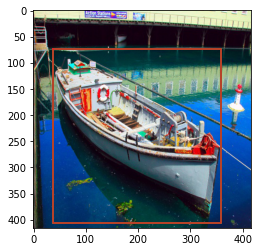

In [55]:
ex_image_id = image_annots.ImageID.values[700]
ex_img_path = os.path.join(FRAME_PATH, "{}.jpg".format(ex_image_id))
ex_label_path = os.path.join(MASK_PATH, "{}.txt".format(ex_image_id))

plt.imshow(cv2.cvtColor(cv2.imread(ex_img_path),cv2.COLOR_BGR2RGB))
    
with open(ex_label_path, "r") as f:
    for line in f:
        x = line.strip().split()
        class_name  = x[0]
        rcx, rcy, rw, rh = [float(i) for i in x[1:]]
        x = (rcx-rw/2)*dim[0]
        y = (rcy-rh/2)*dim[1]
        w = rw*dim[0]
        h = rh*dim[1]
        plt.plot([x, x, x+w, x+w, x], [y, y+h, y+h, y, y])

In [56]:
def write_train_list(METADATA_PATH, FRAME_PATH, name, series):
    list_fp = os.path.join(METADATA_PATH, name)

    with open(list_fp, "w") as f:
        for image_id in series:
            line = "{}\n".format(os.path.join(FRAME_PATH, "{}.jpg".format(image_id)))
            f.write(line)

In [57]:
image_annots.shape

(4652, 2)

In [58]:
tr_series, val_test_series = train_test_split(image_annots['ImageID'], test_size=0.2, random_state=random_stat)
test_series, val_series = train_test_split(val_test_series, test_size=0.5, random_state=random_stat)

print(f'The # of train set: {tr_series.shape[0]}, The # of validation set: {val_series.shape[0]} \
The # of test set: {test_series.shape[0]}')

# train image path list
write_train_list(METADATA_PATH, FRAME_PATH, "tr_list.txt", tr_series)
# validation image path list
write_train_list(METADATA_PATH, FRAME_PATH, "val_list.txt", val_series)
# test image path list
write_train_list(METADATA_PATH, FRAME_PATH, "test_list.txt", test_series)

The # of train set: 3721, The # of validation set: 466 The # of test set: 465


In [59]:
#Esto no funciona pero tampoco se para que sirve si ya tenemos la metadata con trin y validation lists (paths imagenes)

#La idea es crear test images. Se puede mirar luego

In [60]:
data_extention_file_path = os.path.join(CONFIG_PATH, 'ih_fp.data')
with open(data_extention_file_path, 'w') as f:
    contents = """classes= 1
train  = {}
valid  = {}
names  = {}
backup = {}
    """.format(os.path.join(METADATA_PATH, "tr_list.txt"),
               os.path.join(METADATA_PATH, "val_list.txt"),
               os.path.join(CONFIG_PATH, 'ih_fp.names'),
               BACKUP_PATH)
    f.write(contents)

In [61]:
!cat cfg/ih_fp.data

classes= 1
train  = /home/jupyter/metadata/tr_list.txt
valid  = /home/jupyter/metadata/val_list.txt
names  = /home/jupyter/cfg/ih_fp.names
backup = /home/jupyter/backup
    

In [62]:
!echo "boat" > cfg/ih_fp.names

In [63]:
!cd darknet

In [64]:
print(dim)

(416, 416)


In [65]:
!./darknet_gpu detector train cfg/ih_fp.data cfg/yolov3_ih_fp.cfg darknet53.conv.74 -i 0 | tee train_log.txt

layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  32  0.299 BFLOPs
    1 conv     64  3 x 3 / 2   416 x 416 x  32   ->   208 x 208 x  64  1.595 BFLOPs
    2 conv     32  1 x 1 / 1   208 x 208 x  64   ->   208 x 208 x  32  0.177 BFLOPs
    3 conv     64  3 x 3 / 1   208 x 208 x  32   ->   208 x 208 x  64  1.595 BFLOPs
    4 res    1                 208 x 208 x  64   ->   208 x 208 x  64
    5 conv    128  3 x 3 / 2   208 x 208 x  64   ->   104 x 104 x 128  1.595 BFLOPs
    6 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64  0.177 BFLOPs
    7 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128  1.595 BFLOPs
    8 res    5                 104 x 104 x 128   ->   104 x 104 x 128
    9 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64  0.177 BFLOPs
   10 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128  1.595 BFLOPs
   11 res    8                 104 x 

Text(0, 0.5, 'Loss')

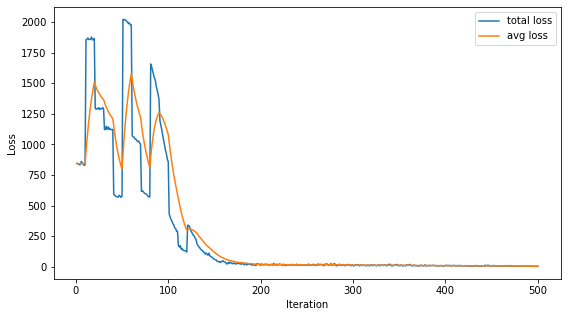

In [66]:
iters = []
losses = []
total_losses = []
with open("train_log.txt", 'r') as f:
    for i,line in enumerate(f):
        if "images" in line:
            iters.append(int(line.strip().split()[0].split(":")[0]))
            losses.append(float(line.strip().split()[2]))        
            total_losses.append(float(line.strip().split()[1].split(',')[0]))

plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
sns.lineplot(iters, total_losses, label="total loss")
sns.lineplot(iters, losses, label="avg loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")

In [45]:
import shutil
#shutil.copy(ex_img_path, "test.jpg")

'test.jpg'

In [95]:
#!ls -alsth backup

In [96]:
#Test de 1 imagen pero no se para que sirve

#!cd darknet && ./darknet detector test ../cfg/ih_fp.data ../cfg/yolov3_ih_fp.cfg_test ../backup/yolov3_ih_fp_final.weights ../test.jpg -thresh 0.005

In [52]:
#![](predictions.jpg)

In [53]:
#plt.imshow(cv2.imread("./darknet/predictions.jpg"))

In [67]:
from ctypes import *

In [68]:
lib = CDLL("./darknet/libdarknet.so", RTLD_GLOBAL)
darknet_lib_path = os.path.join(os.getcwd(), "darknet", "libdarknet.so")
lib = CDLL(darknet_lib_path, RTLD_GLOBAL)

In [69]:
#!wget --no-check-certificate -q "https://docs.google.com/uc?export=download&id=1-KTV7K9G1bl3SmnLnzmpkDyNt6tDmH7j" -O darknet.py

In [70]:
from darknet import *

In [71]:
threshold = 0.2

In [72]:
submit_file_path = "submission.csv"
cfg_path_2 = os.path.join(CONFIG_PATH, "yolov3_ih_fp.cfg_test")
weight_path = os.path.join(BACKUP_PATH, "yolov3_ih_fp_final.weights")

test_img_list_path = os.path.join(METADATA_PATH, "test_list.txt")

In [73]:
load_net = lib.load_network
load_meta = lib.get_metadata
load_image = lib.load_image_color

In [74]:
gpu_index = 0
net = load_net(cfg_path_2.encode(),
               weight_path.encode(), 
               gpu_index)

In [75]:
meta = load_meta(data_extention_file_path.encode())

In [129]:
submit_dict = {"ImageId": [], "PredictionString": []}

with open(test_img_list_path, "r") as test_img_list_f:
    # tqdm run up to 1000(The # of test set)
    for line in tqdm(test_img_list_f):
        image_id = line.strip().split('/')[-1].strip().split('.')[0]
        infer_result = detect(net, meta, line.strip().encode(), thresh=threshold)
        submit_line = ""
        for e in infer_result:
            label = e[0]
            confi = e[1]

            rw = e[2][2]
            rh = e[2][3]
            rcx = e[2][0]
            rcy = e[2][1]
           
            
            submit_line += "{} {} {} {} {} ".format(confi, rcx, rcy, rw, rh)
        submit_dict["ImageId"].append(image_id)
        submit_dict["PredictionString"].append(submit_line)

pd.DataFrame(submit_dict).to_csv(submit_file_path, index=False)

465it [00:44, 10.55it/s]


In [ ]:
    rw = (XMax - XMin)
    rh = (YMax - YMin)
    rcx = XMin + rw/2
    rcy = YMin + rh/2

    line = "{} {} {} {} {}\n".format(label, rcx, rcy, rw, rh)

In [130]:
submissions = pd.read_csv('submission.csv')

In [131]:
submissions[submissions['PredictionString'].notnull()].head(12)

,ImageId,PredictionString
7,02c1f4f557ee3d67,0.26178985834121704 78.25704956054688 302.5886...
8,dad3c66dde6fedce,0.2146371304988861 143.34556579589844 207.4018...
16,aa0c69c94cb0db55,0.3760286569595337 86.61489868164062 265.94152...
18,dc16da660faf8377,0.26185041666030884 68.84211730957031 213.4785...
25,ec7c4182bd9be5a6,0.2075931578874588 141.30865478515625 266.7794...
37,1b0aa46b136c9bb6,0.22531872987747192 85.11759948730469 338.6072...
41,a76ac642cd1c9839,0.35690727829933167 113.2437973022461 337.5246...
51,7ad97d60756cc575,0.4171573519706726 139.91566467285156 212.5593...
56,a7f8e38251e918f2,0.21064859628677368 233.89398193359375 314.085...
59,dc6999dc2970710e,0.26352834701538086 212.21697998046875 296.967...


0.4171573519706726 139.91566467285156 212.55935668945312 236.37960815429688 164.56712341308594 


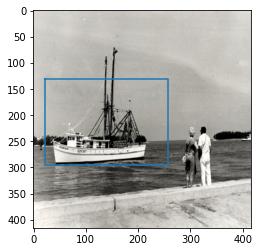

In [134]:
ex_image_id = '7ad97d60756cc575'
ex_img_path = os.path.join(FRAME_PATH, "{}.jpg".format(ex_image_id))
#ex_label_path = os.path.join(MASK_PATH, "{}.txt".format(ex_image_id))
df_predict = submissions['PredictionString'][submissions['ImageId']==ex_image_id]

plt.imshow(cv2.cvtColor(cv2.imread(ex_img_path),cv2.COLOR_BGR2RGB))

for row in df_predict:
    print(row)
    p = row.strip().split()
    confianza  = p[0]
    rcx, rcy, rw, rh = [float(i) for i in p[1:]]
    x = rcx - rw/2
    y = rcy - rh/2
    w = rw
    h = rh
    plt.plot([x, x, x+w, x+w, x], [y, y+h, y+h, y, y])
